# Amazon Fine Food Review- Using Logisitc Regression

In [1]:
# imported necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split, cross_val_score
#from sklearn.cross_validation import cross_val_score
from collections import Counter
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
from sklearn import model_selection
#from sklearn import cross_validation
from scipy.stats import uniform
from sklearn.model_selection import TimeSeriesSplit

In [2]:
warnings.filterwarnings("ignore")

In [3]:
import sqlite3
con = sqlite3.connect('finalassignment.sqlite')

In [4]:
cleaned_data = pd.read_sql_query('select * from Reviews', con)

In [5]:
cleaned_data.shape

(364171, 12)

In [6]:
# Sort data based on time
cleaned_data["Time"] = pd.to_datetime(cleaned_data["Time"], unit = "s")
cleaned_data = cleaned_data.sort_values(by = "Time")
cleaned_data.shape

(364171, 12)

In [7]:
cleaned_data['Score'].value_counts()

positive    307061
negative     57110
Name: Score, dtype: int64

In [8]:
# To randomly sample 5k points from both class

data_p = cleaned_data[cleaned_data['Score'] == 'positive'].sample(n = 5000)
data_n = cleaned_data[cleaned_data['Score'] == 'negative'].sample(n = 5000)
final_10k = pd.concat([data_p, data_n])
final_10k.shape

(10000, 12)

In [9]:
# converting scores in 0 and 1
final_10k["Score"] = final_10k["Score"].map(lambda x: 1 if x == "positive" else 0)
#encoded_labels = df['label'].map(lambda x: 1 if x == 'spam' else 0).values

In [10]:
# Sorting data based on time
final_10k['Time'] = pd.to_datetime(final_10k['Time'], unit = 's')
final_10k = final_10k.sort_values(by = 'Time')
final_10k.shape

(10000, 12)

# Bag Of Word (BOW)

in this bow technique  we using grid search. In a grid search we using list for find a C like [0.01 , 0.1 , 1 , 10] etc. 

In [11]:
# Grid search
def lr_grid_plot(X_train, y_train):
    tuned_parameters_grid = [{'penalty': ['l1','l2'],'C': [10**-4, 10**-2, 10**0, 10**2, 10**4]}]
    cv = TimeSeriesSplit(n_splits = 3)
    model_lr_grid = GridSearchCV(LogisticRegression(solver = 'liblinear'), param_grid = tuned_parameters_grid, cv = cv)
    model_lr_grid.fit(X_train, y_train)
    print("\n**********GridSearchCV**********\n")
    print("\nOptimal C:", model_lr_grid.best_estimator_.C)
    print('\nBest penalty:', model_lr_grid.best_estimator_.get_params()['penalty'])
    score = model_lr_grid.cv_results_
    plot_df = pd.DataFrame(score)
    plt.plot(plot_df["param_C"], 1- plot_df["mean_test_score"], "-o")
    plt.title("CV Error vs C")
    plt.xlabel("C")
    plt.ylabel("Cross-validation Error")
    plt.show()
    return model_lr_grid.best_estimator_.C

In [12]:
# 10k data which will use to train model after vectorization
X = final_10k["CleanedText"]
print("shape of X:", X.shape)

shape of X: (10000,)


In [13]:
# class label
y = final_10k["Score"]
print("shape of y:", y.shape)

shape of y: (10000,)


In [14]:
# split data into train and test where 70% data used to train model and 30% for test
from sklearn.model_selection import train_test_split
X_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42, shuffle = False)
print(X_train.shape, y_train.shape, x_test.shape , y_test.shape)

(7000,) (7000,) (3000,) (3000,)


In [15]:
# Train Vectorizor
from sklearn.feature_extraction.text import CountVectorizer 
bow = CountVectorizer()
X_train = bow.fit_transform(X_train)
X_train

<7000x12589 sparse matrix of type '<class 'numpy.int64'>'
	with 218873 stored elements in Compressed Sparse Row format>

In [16]:
# Standardization 
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler(with_mean = False)
std_X_train = scaler.fit_transform(X_train)

In [17]:
# Test Vectorizor
x_test = bow.transform(x_test)
x_test.shape

(3000, 12589)

In [18]:
scaler = StandardScaler(with_mean = False)
std_x_test = scaler.fit_transform(x_test)

In [19]:
std_x_test.shape

(3000, 12589)


**********GridSearchCV**********


Optimal C: 1

Best penalty: l1


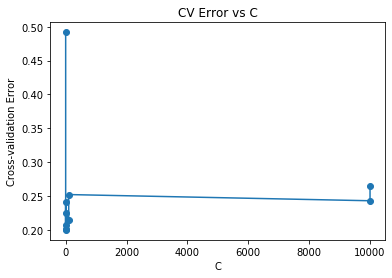

1

In [20]:
# To choose optimal c using cross validation
from sklearn.model_selection import TimeSeriesSplit
optimal_lambda_bow_grid = lr_grid_plot(std_X_train, y_train)
optimal_lambda_bow_grid

In [161]:
# instantiate learning model 
lr_model =  LogisticRegression(penalty = 'l1', C = optimal_lambda_bow_grid, class_weight = "balanced" , solver = 'liblinear')
# fitting the model
lr_model.fit(std_X_train, y_train)
# predict the response
pred = lr_model.predict(std_x_test)
# predict probablistic response
pred_prob = lr_model.predict_proba(std_x_test)

# this step use both technique

In [162]:
train_acc_bow_grid = lr_model.score(std_X_train, y_train)
print("Train accuracy:",train_acc_bow_grid)

Train accuracy: 0.7687142857142857


In [163]:
test_acc_bow_grid = accuracy_score(y_test, pred) * 100
print('\nThe accuracy of the logistic regression for c = %f is %.2f%%' % (optimal_lambda_bow_grid, test_acc_bow_grid))


The accuracy of the logistic regression for c = 1.000000 is 53.63%


In [164]:
# Confusion Matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, pred)
cm

array([[1604,    1],
       [1390,    5]], dtype=int64)

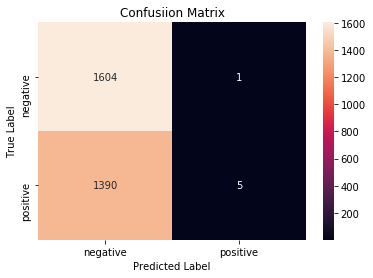

In [165]:
# plot confusion matrix to describe the performance of classifier.
import seaborn as sns
class_label = ["negative", "positive"]
df_cm = pd.DataFrame(cm, index = class_label, columns = class_label)
sns.heatmap(df_cm, annot = True, fmt = "d")
plt.title("Confusiion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [166]:
# To show main classification report
from sklearn.metrics import classification_report
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       0.54      1.00      0.70      1605
           1       0.83      0.00      0.01      1395

    accuracy                           0.54      3000
   macro avg       0.68      0.50      0.35      3000
weighted avg       0.67      0.54      0.38      3000



In [167]:
# model for knn with bag of word
models = pd.DataFrame({'Model': ['Logistic Regression with Bow'], 'Hyper Parameter(K) for grid search': [optimal_lambda_bow_grid], 'Train Error': [train_acc_bow_grid], 'Test Error': [100 - test_acc_bow_grid], 'Accuracy': [test_acc_bow_grid ], 'Train Accuracy': [train_acc_bow_grid ]}, columns = ["Model", "Hyper Parameter(K) for grid search", "Train Error", "Test Error", "Accuracy" , "Train Accuracy"])
models.sort_values(by='Accuracy', ascending=False)

,Model,Hyper Parameter(K) for grid search,Train Error,Test Error,Accuracy,Train Accuracy
0,Logistic Regression with Bow,1,0.768714,46.366667,53.633333,0.768714


this time i don't know what use this step.

In [28]:
def plot_precision_recall_curve(recall, precision):
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title("Precision_recall_curve")
    plt.plot(recall, precision, "-o")
    plt.show()

Average precision score: 0.8373070795974974
F1_score: 0.7897146882705178
Auc score: 0.8373881125897341


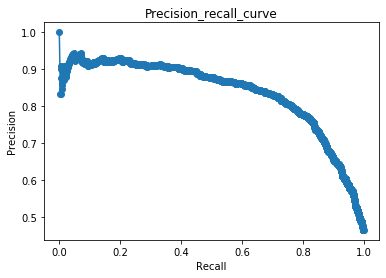

In [29]:
# F1-score, auc, precision_recall_curve
from sklearn.metrics import f1_score, auc, precision_recall_curve, average_precision_score
from sklearn.metrics import auc
f1 = f1_score(y_test, pred)
precision, recall, thresholds = precision_recall_curve(y_test, pred_prob[:,1])
auc = auc(recall, precision)
avg_precision = average_precision_score(y_test, pred_prob[:,1])
print("Average precision score:", avg_precision)
print("F1_score:", f1)
print("Auc score:",auc)
plot_precision_recall_curve(recall, precision)

Now we use random search technique and find best C and in this random search we using interval like[10^-4,10^4] and search best c .

In [30]:
# Random search
from scipy.stats import uniform
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
def lr_random_plot(X_train, y_train):
    tuned_parameters_random = {'penalty': ['l1','l2'], 'C': uniform(loc = 0, scale = 4)}
    cv = TimeSeriesSplit(n_splits = 3)
    model_lr_random = RandomizedSearchCV(LogisticRegression(solver = 'liblinear'), tuned_parameters_random, cv = cv, n_iter = 10)
    model_lr_random.fit(X_train, y_train)
    print("\n\n**********RandomizedSearchCV**********\n")
    print("\nOptimal C:", model_lr_random.best_estimator_.C)
    print('\nBest penalty:', model_lr_random.best_estimator_.get_params()['penalty'])
    score = model_lr_random.cv_results_
    plot_df = pd.DataFrame(score)
    plt.plot(plot_df["param_C"], 1 - plot_df["mean_test_score"], "-o")
    plt.title("CV Error vs C")
    plt.xlabel("C")
    plt.ylabel("Cross-validation Error")
    plt.show()
    return model_lr_random.best_estimator_.C



**********RandomizedSearchCV**********


Optimal C: 2.3313325867997166

Best penalty: l1


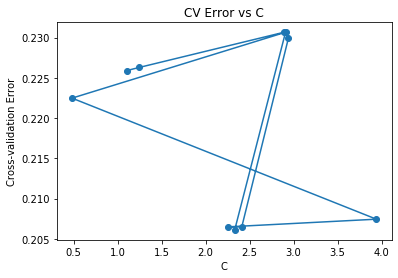

2.3313325867997166

In [31]:
optimal_lambda_bow_random = lr_random_plot(std_X_train, y_train)
optimal_lambda_bow_random

In [32]:
# instantiate learning model 
lr_model =  LogisticRegression(penalty = 'l2', C = optimal_lambda_bow_grid, class_weight = "balanced")
# fitting the model
lr_model.fit(std_X_train, y_train)
# predict the response
pred = lr_model.predict(std_x_test)
# predict probablistic response
pred_prob = lr_model.predict_proba(std_x_test)

# this step use both technique

In [33]:
train_acc_bow_random = lr_model.score(std_X_train, y_train)
print("Train accuracy:",train_acc_bow_random)

Train accuracy: 1.0


In [34]:
test_acc_bow_random = accuracy_score(y_test, pred) * 100
print('\nThe accuracy of the logistic regression for c = %f is %.2f%%' % (optimal_lambda_bow_random, test_acc_bow_random))


The accuracy of the logistic regression for c = 2.331333 is 80.10%


In [35]:
# Confusion Matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, pred)
cm

array([[1282,  323],
       [ 274, 1121]], dtype=int64)

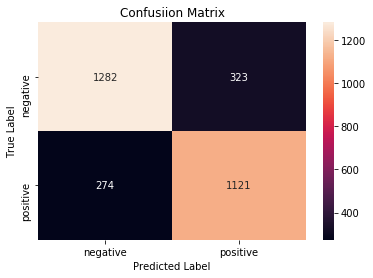

In [36]:
# plot confusion matrix to describe the performance of classifier.
import seaborn as sns
class_label = ["negative", "positive"]
df_cm = pd.DataFrame(cm, index = class_label, columns = class_label)
sns.heatmap(df_cm, annot = True, fmt = "d")
plt.title("Confusiion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [37]:
# To show main classification report
from sklearn.metrics import classification_report
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       0.82      0.80      0.81      1605
           1       0.78      0.80      0.79      1395

    accuracy                           0.80      3000
   macro avg       0.80      0.80      0.80      3000
weighted avg       0.80      0.80      0.80      3000



In [38]:
# model for knn with bag of word
modelsgrid = pd.DataFrame({'Model': ['Logistic Regression with Bow'], 'Hyper Parameter(K) for random search': [optimal_lambda_bow_random], 'Train Error': [train_acc_bow_random], 'Test Error': [100 - test_acc_bow_random], 'Accuracy': [test_acc_bow_random ], 'Train Accuracy': [train_acc_bow_random ]}, columns = ["Model", "Hyper Parameter(K) for random search", "Train Error", "Test Error", "Accuracy" , "Train Accuracy"])
modelsgrid.sort_values(by='Accuracy', ascending=False)


,Model,Hyper Parameter(K) for random search,Train Error,Test Error,Accuracy,Train Accuracy
0,Logistic Regression with Bow,2.331333,1.0,19.9,80.1,1.0


now we find f1 score and acc..

In [39]:
def plot_precision_recall_curve(recall, precision):
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title("Precision_recall_curve")
    plt.plot(recall, precision, "-o")
    plt.show()

Average precision score: 0.8373070795974974
F1_score: 0.7897146882705178
Auc score: 0.8373881125897341


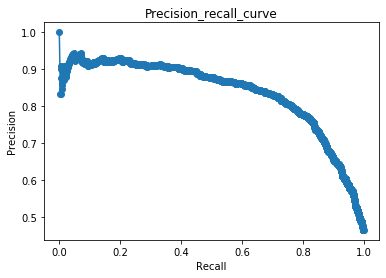

In [40]:
# F1-score, auc, precision_recall_curve
from sklearn.metrics import f1_score, auc, precision_recall_curve, average_precision_score
from sklearn.metrics import auc
f1 = f1_score(y_test, pred)
precision, recall, thresholds = precision_recall_curve(y_test, pred_prob[:,1])
auc = auc(recall, precision)
avg_precision = average_precision_score(y_test, pred_prob[:,1])
print("Average precision score:", avg_precision)
print("F1_score:", f1)
print("Auc score:",auc)
plot_precision_recall_curve(recall, precision)

In [41]:
# Tried different value of c and finding features weight
# More Sparsity (Fewer elements of W* being non-zero) by increasing Lambda (decreasing C)
C_param = [10, 1, 0.1]

for c in C_param:
    clf = LogisticRegression(penalty='l1', C = c, class_weight = "balanced",  solver='liblinear')
    clf.fit(X_train, y_train)
    print('\nC value:', c)
    print('Coefficient of each feature:', clf.coef_)
    print('Training accuracy: %0.2f%%' %(clf.score(std_X_train, y_train) * 100))
    print('Test accuracy: %0.2f%%' %(clf.score(std_x_test, y_test) * 100))
    print("Number of non-zero element: ",np.count_nonzero(clf.coef_))


C value: 10
Coefficient of each feature: [[0. 0. 0. ... 0. 0. 0.]]
Training accuracy: 91.66%
Test accuracy: 74.23%
Number of non-zero element:  2157

C value: 1
Coefficient of each feature: [[0. 0. 0. ... 0. 0. 0.]]
Training accuracy: 91.53%
Test accuracy: 78.73%
Number of non-zero element:  1307

C value: 0.1
Coefficient of each feature: [[0. 0. 0. ... 0. 0. 0.]]
Training accuracy: 84.54%
Test accuracy: 83.23%
Number of non-zero element:  258


# Checking for multicollinearity using pertubation test

In [42]:
clf = LogisticRegression(penalty='l1', C = optimal_lambda_bow_random, class_weight = "balanced" ,solver='liblinear')
clf.fit(std_X_train, y_train)
y_pred = clf.predict(std_x_test)
print("Accuracy score: %0.2f%%" %(accuracy_score(y_test, y_pred) * 100))
print(np.count_nonzero(clf.coef_))

Accuracy score: 81.87%
3421


In [43]:
std_X_train.shape

(7000, 12589)

In [44]:
from scipy.sparse import find

# Before adding noise in data
cf = clf.coef_[0]
w_coef1 = cf[np.nonzero(cf)]
print(w_coef1[:20])

[-6.82360913e-02  9.84282006e-03  5.90714016e-02  9.93287729e-02
  2.73061582e-03  5.29813433e-02  1.32981706e-01  3.77296249e-02
 -1.70386374e-02 -3.63795721e-02  1.28236055e-01 -1.24626296e-01
 -2.71194448e-02  2.13279085e-06  1.90434530e-01 -4.35799668e-02
 -1.03186582e-01 -4.53110068e-03 -6.48360012e-03 -3.76055710e-02]


In [45]:
# Generate random normal variable as a noise 
std_X_train_pert = std_X_train
noise = np.random.normal(0, 0.0001, size = (std_X_train_pert[np.nonzero(std_X_train_pert)].size))
#print(noise.shape)
np.nonzero(std_X_train_pert)
std_X_train_pert[np.nonzero(std_X_train_pert)] = noise + std_X_train_pert[np.nonzero(std_X_train_pert)]
std_X_train_pert.shape

(7000, 12589)

In [46]:
clf = LogisticRegression(penalty ='l1', C = optimal_lambda_bow_random, class_weight = "balanced", solver='liblinear')
clf.fit(std_X_train_pert, y_train)
y_pred = clf.predict(std_x_test)
print("Accuracy score: %0.2f%%" %(accuracy_score(y_test, y_pred) * 100))
print(np.count_nonzero(clf.coef_))

Accuracy score: 81.57%
3414


In [47]:
cf = clf.coef_[0]
w_coef2 = cf[np.nonzero(cf)]
print(w_coef2[:20])

[-0.06804577  0.01116979  0.07392591  0.09713725  0.00933983  0.10241969
  0.1295182   0.03657514 -0.0185252  -0.00022503  0.12692008 -0.12256549
 -0.02524844  0.02637408  0.18548416 -0.04939926 -0.10235011 -0.00971379
 -0.00782791 -0.04687882]


In [48]:
# Calculate %increase 
cnt = 0
for w1, w2 in zip(w_coef1, w_coef2):
    inc = abs(w1 - w2)/abs(w1) * 100
    if inc > 40:
        cnt += 1
print("No of weights that changes more than 40% is:", cnt)

No of weights that changes more than 40% is: 2843


In [49]:
# Features importance 

features = bow.get_feature_names()
coef = clf.coef_[0]
coeff_df = pd.DataFrame({'Word' : features, 'Coefficient' : coef})
coeff_df = coeff_df.sort_values("Coefficient", ascending = False)
print('*----------****Top 10 positive*------------------****')
print(coeff_df.head(10))
print('**-------------***Top 10 negative**---------------***')
print(coeff_df.tail(10))

*----------****Top 10 positive*------------------****
         Word  Coefficient
4827    great     2.271542
8133  perfect     1.625330
6435     love     1.573194
928      best     1.206193
4707     good     1.037701
3778    excel     0.988556
7364     nice     0.974439
2906   delici     0.966022
286      also     0.933961
4067     find     0.871164
**-------------***Top 10 negative**---------------***
             Word  Coefficient
3155      disgust    -0.833823
702           bad    -0.838252
9892      similac    -0.871170
12414        wors    -0.928068
12424       would    -0.942042
5268      horribl    -0.981748
9174       return    -1.054600
10902        tast    -1.199119
12416       worst    -1.348415
3119   disappoint    -1.665113


# Tf-Idf

Now we using grid search for tfidf and plot a graph and find error , accuracy ,f1 score graph etc.. 

In [50]:
# data
X = final_10k["CleanedText"]

In [51]:
# Target/class-label
y = final_10k["Score"]

In [52]:
# Split data
X_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42, shuffle = False)
print(X_train.shape, x_test.shape, y_train.shape, y_test.shape)

(7000,) (3000,) (7000,) (3000,)


In [53]:
from sklearn.feature_extraction.text import TfidfVectorizer
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2))
X_train = tf_idf_vect.fit_transform(X_train)
X_trn = X_train
X_train

<7000x182674 sparse matrix of type '<class 'numpy.float64'>'
	with 474789 stored elements in Compressed Sparse Row format>

In [54]:
# Standardization 
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler(with_mean = False)
std_X_train = scaler.fit_transform(X_train)

In [55]:
# Convert test text data to its vectorizor
x_test = tf_idf_vect.transform(x_test)
x_tst = x_test
x_test.shape

(3000, 182674)

In [56]:
scaler = StandardScaler(with_mean = False)
std_x_test = scaler.fit_transform(x_test)


**********GridSearchCV**********


Optimal C: 1

Best penalty: l1


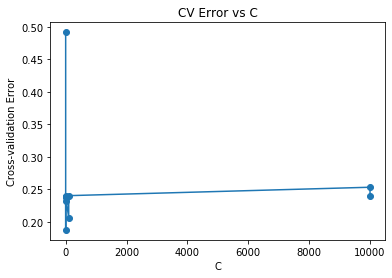

1

In [57]:
# To choose optimal_alpha using nested cross validation
optimal_lambda_tfidf_grid = lr_grid_plot(std_X_train, y_train)
optimal_lambda_tfidf_grid

In [58]:
# instantiate learning model 
lr_model =  LogisticRegression(penalty = 'l2', C = optimal_lambda_tfidf_grid, class_weight = "balanced")
# fitting the model
lr_model.fit(std_X_train, y_train)
# predict the response
pred = lr_model.predict(std_x_test)
# predict probablistic response
pred_prob = lr_model.predict_proba(std_x_test)

Average precision score: 0.9084271735460614
F1_score: 0.8170850994457124
Auc score: 0.9083833601198805


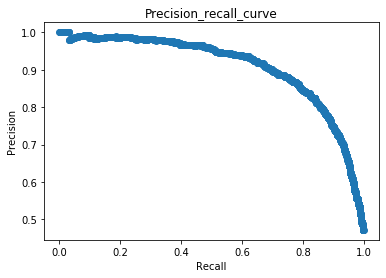

In [59]:
# F1-score, auc, precision_recall_curve
from sklearn.metrics import f1_score, auc, precision_recall_curve, average_precision_score
from sklearn.metrics import auc
f1 = f1_score(y_test, pred)
precision, recall, thresholds = precision_recall_curve(y_test, pred_prob[:,1])
auc = auc(recall, precision)
avg_precision = average_precision_score(y_test, pred_prob[:,1])
print("Average precision score:", avg_precision)
print("F1_score:", f1)
print("Auc score:",auc)
plot_precision_recall_curve(recall, precision)

In [60]:
train_acc_tfidf_grid = lr_model.score(std_X_train, y_train)
print("Train accuracy:",train_acc_tfidf_grid)

Train accuracy: 1.0


In [61]:
test_acc_tfidf_grid = accuracy_score(y_test, pred) * 100
print('\nThe accuracy of the logistic regression for c = %f is %.2f%%' % (optimal_lambda_tfidf_grid, test_acc_tfidf_grid))


The accuracy of the logistic regression for c = 1.000000 is 81.30%


In [62]:
# Confusion Matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, pred)
cm

array([[1186,  419],
       [ 142, 1253]], dtype=int64)

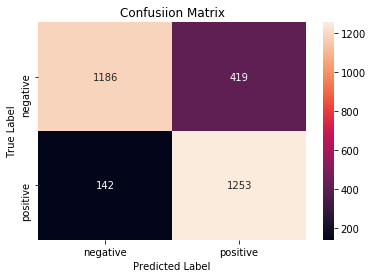

In [63]:
# plot confusion matrix to describe the performance of classifier.
import seaborn as sns
class_label = ["negative", "positive"]
df_cm = pd.DataFrame(cm, index = class_label, columns = class_label)
sns.heatmap(df_cm, annot = True, fmt = "d")
plt.title("Confusiion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [64]:
# To show main classification report
from sklearn.metrics import classification_report
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       0.89      0.74      0.81      1605
           1       0.75      0.90      0.82      1395

    accuracy                           0.81      3000
   macro avg       0.82      0.82      0.81      3000
weighted avg       0.83      0.81      0.81      3000



In [65]:
# model for knn with bag of word
modelsgrid = pd.DataFrame({'Model': ['Logistic Regression with TFIDF'], 'Hyper Parameter(K) for grid search': [optimal_lambda_tfidf_grid], 'Train Error': [train_acc_tfidf_grid], 'Test Error': [100 - test_acc_tfidf_grid], 'Accuracy': [test_acc_tfidf_grid ], 'Train Accuracy': [train_acc_tfidf_grid ]}, columns = ["Model", "Hyper Parameter(K) for grid search", "Train Error", "Test Error", "Accuracy" , "Train Accuracy"])
modelsgrid.sort_values(by='Accuracy', ascending=False)


,Model,Hyper Parameter(K) for grid search,Train Error,Test Error,Accuracy,Train Accuracy
0,Logistic Regression with TFIDF,1,1.0,18.7,81.3,1.0


Now we using random search for tfidf and plot a graph and find error , accuracy ,f1 score graph etc.. 



**********RandomizedSearchCV**********


Optimal C: 3.762733693938149

Best penalty: l1


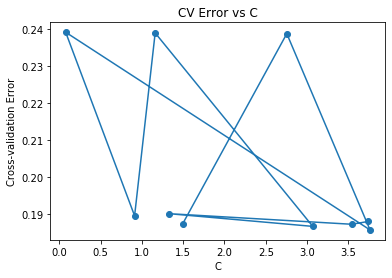

3.762733693938149

In [66]:
optimal_lambda_tfidf_random = lr_random_plot(std_X_train, y_train)
optimal_lambda_tfidf_random

In [67]:
# instantiate learning model 
lr_model =  LogisticRegression(penalty = 'l2', C = optimal_lambda_tfidf_random, class_weight = "balanced")
# fitting the model
lr_model.fit(std_X_train, y_train)
# predict the response
pred = lr_model.predict(std_x_test)
# predict probablistic response
pred_prob = lr_model.predict_proba(std_x_test)

Average precision score: 0.9081278131174135
F1_score: 0.8173515981735159
Auc score: 0.9080836633561873


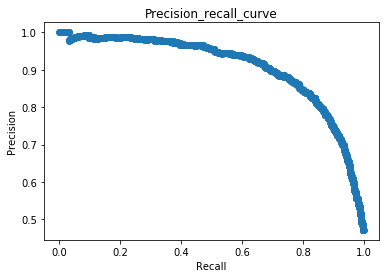

In [68]:
# F1-score, auc, precision_recall_curve
from sklearn.metrics import f1_score, auc, precision_recall_curve, average_precision_score
from sklearn.metrics import auc
f1 = f1_score(y_test, pred)
precision, recall, thresholds = precision_recall_curve(y_test, pred_prob[:,1])
auc = auc(recall, precision)
avg_precision = average_precision_score(y_test, pred_prob[:,1])
print("Average precision score:", avg_precision)
print("F1_score:", f1)
print("Auc score:",auc)
plot_precision_recall_curve(recall, precision)

In [69]:
train_acc_tfidf_random = lr_model.score(std_X_train, y_train)
print("Train accuracy %f%%:" % (train_acc_tfidf_random))

Train accuracy 1.000000%:


In [70]:
test_acc_tfidf_random = accuracy_score(y_test, pred) * 100
print('\nThe accuracy of the logistic regression for c = %f is %.2f%%' % (optimal_lambda_tfidf_random, test_acc_tfidf_random))


The accuracy of the logistic regression for c = 3.762734 is 81.33%


In [71]:
# Confusion Matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, pred)
cm

array([[1187,  418],
       [ 142, 1253]], dtype=int64)

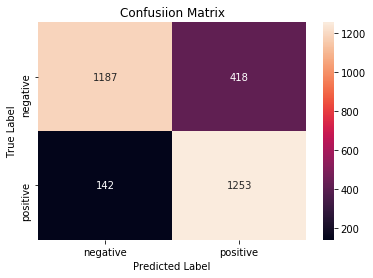

In [72]:
# plot confusion matrix to describe the performance of classifier.
import seaborn as sns
class_label = ["negative", "positive"]
df_cm = pd.DataFrame(cm, index = class_label, columns = class_label)
sns.heatmap(df_cm, annot = True, fmt = "d")
plt.title("Confusiion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [73]:
# To show main classification report
from sklearn.metrics import classification_report
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       0.89      0.74      0.81      1605
           1       0.75      0.90      0.82      1395

    accuracy                           0.81      3000
   macro avg       0.82      0.82      0.81      3000
weighted avg       0.83      0.81      0.81      3000



In [74]:
# model for knn with bag of word
modelsgrid = pd.DataFrame({'Model': ['Logistic Regression with TFIDF'], 'Hyper Parameter(K) for random search': [optimal_lambda_tfidf_random], 'Train Error': [train_acc_tfidf_random], 'Test Error': [100 - test_acc_tfidf_random], 'Accuracy': [test_acc_tfidf_random ], 'Train Accuracy': [train_acc_tfidf_random ]}, columns = ["Model", "Hyper Parameter(K) for random search", "Train Error", "Test Error", "Accuracy" , "Train Accuracy"])
modelsgrid.sort_values(by='Accuracy', ascending=False)


,Model,Hyper Parameter(K) for random search,Train Error,Test Error,Accuracy,Train Accuracy
0,Logistic Regression with TFIDF,3.762734,1.0,18.666667,81.333333,1.0


In [75]:
# Tried different value of c and finding features weight
# More Sparsity (Fewer elements of W* being non-zero) by increasing Lambda (decreasing C)
C_param = [10, 1, 0.1]

for c in C_param:
    clf = LogisticRegression(penalty = 'l2', C = c, class_weight = "balanced")
    clf.fit(X_train, y_train)
    print('\nC value:', c)
    print('Coefficient of each feature:', clf.coef_)
    print('Training accuracy: %0.3f%%' %(clf.score(std_X_train, y_train) * 100))
    print('Test accuracy: %0.3f%%' %(clf.score(std_x_test, y_test) * 100))
    print("Number of non-zero element: ",np.count_nonzero(clf.coef_))


C value: 10
Coefficient of each feature: [[-0.04368038 -0.04368038  0.06177821 ...  0.15079604 -0.08385803
  -0.08385803]]
Training accuracy: 100.000%
Test accuracy: 85.033%
Number of non-zero element:  182674

C value: 1
Coefficient of each feature: [[-0.01693831 -0.01693831  0.01764469 ...  0.04426715 -0.02509965
  -0.02509965]]
Training accuracy: 99.986%
Test accuracy: 86.133%
Number of non-zero element:  182674

C value: 0.1
Coefficient of each feature: [[-0.00366251 -0.00366251  0.00266066 ...  0.00912528 -0.00374337
  -0.00374337]]
Training accuracy: 99.414%
Test accuracy: 84.533%
Number of non-zero element:  182674


# Checking for multicollinearity using pertubation test

In [76]:
clf = LogisticRegression(penalty = 'l1', C = optimal_lambda_tfidf_grid, class_weight = "balanced" ,solver='liblinear')
clf.fit(std_X_train, y_train)
y_pred = clf.predict(std_x_test)
print("Accuracy score: %.2f%%" %(accuracy_score(y_test, y_pred) * 100))
print(np.count_nonzero(clf.coef_))

Accuracy score: 84.73%
11305


In [77]:
std_X_train.shape

(7000, 182674)

In [78]:
np.count_nonzero(clf.coef_)

11305

In [79]:
from scipy.sparse import find

# Before adding noise in data
cf = clf.coef_[0]
w_coef1 = cf[np.nonzero(cf)]
print(w_coef1[:20])

[ 6.76085757e-04 -3.31644637e-03  2.03048865e-02  2.44770318e-02
  7.50253453e-02 -4.19811117e-03  7.66901670e-03 -2.85469702e-04
  1.60074497e-02 -2.82603230e-03  1.95213239e-03  3.64906300e-04
  1.64987013e-06  3.26944277e-02  1.65077868e-02  1.82014981e-03
  1.59860008e-01 -2.58591668e-04  6.67361382e-03  1.30474941e-02]


In [80]:
# Generate random normal variable as a noise 
std_X_train_pert = std_X_train
noise = np.random.normal(0, 0.001, size = (std_X_train_pert[np.nonzero(std_X_train_pert)].size,))
#print(noise.shape)
np.nonzero(std_X_train_pert)
std_X_train_pert[np.nonzero(std_X_train_pert)] = noise + std_X_train_pert[np.nonzero(std_X_train_pert)]
std_X_train_pert.shape

(7000, 182674)

In [81]:
std_X_train_pert.shape

(7000, 182674)

In [82]:
clf = LogisticRegression(penalty = 'l2', C = optimal_lambda_tfidf_grid, class_weight = "balanced")
clf.fit(std_X_train_pert, y_train)
y_pred = clf.predict(std_x_test)
print("Accuracy score: %0.2f%%" %(accuracy_score(y_test, y_pred) * 100))
print(np.count_nonzero(clf.coef_))

Accuracy score: 81.30%
182674


In [83]:
np.count_nonzero(clf.coef_)

182674

In [84]:
cf = clf.coef_[0]
w_coef2 = cf[np.nonzero(cf)]
print(w_coef2[:20])

[-0.00160401 -0.00160403  0.00119261  0.00119261 -0.0087385  -0.00873857
 -0.01210846 -0.00078588 -0.0042517   0.00281643  0.00161061  0.00161061
 -0.00157237 -0.00062195 -0.00144883  0.0012489  -0.00049938  0.00153296
 -0.00481822 -0.00209584]


In [85]:
# Calculate %increase 
cnt = 0
for w1, w2 in zip(w_coef1, w_coef2):
    inc = abs(w1 - w2)/abs(w1) * 100
    if inc > 40:
        cnt += 1
print("No of weights that changes more than 40% is:", cnt)

No of weights that changes more than 40% is: 10560


In [86]:
# Features importance 

features = tf_idf_vect.get_feature_names()
coef = clf.coef_[0]
coeff_df = pd.DataFrame({'Word' : features, 'Coefficient' : coef})
coeff_df = coeff_df.sort_values('Coefficient', ascending = 0)
print('*****Top 10 positive*****')
print(coeff_df.head(10))
print('*****Top 10 negative*****')
print(coeff_df.tail(10))

*****Top 10 positive*****
           Word  Coefficient
71544     great     0.143126
93954      love     0.113829
14297      best     0.093115
42495    delici     0.078552
117607  perfect     0.069257
57664   favorit     0.063202
59277      find     0.059077
161834    thank     0.058262
69561      good     0.054345
106606     nice     0.053211
*****Top 10 negative*****
              Word  Coefficient
77618      horribl    -0.058025
159047   tast like    -0.058615
102544       money    -0.060819
158608        tast    -0.061784
175326  wast money    -0.063306
180216       worst    -0.063472
175279        wast    -0.065159
10564          bad    -0.068718
153255   store per    -0.071375
45133   disappoint    -0.099044


# Word2vec

In [87]:
# data
X = final_10k["Text"]
X.shape

(10000,)

In [88]:
# Target/class-label
y = final_10k["Score"]
y.shape

(10000,)

In [89]:
# Split data
X_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42, shuffle = False)
print(X_train.shape, x_test.shape, y_train.shape, y_test.shape)

(7000,) (3000,) (7000,) (3000,)


In [90]:
import re
def cleanhtml(sentence): #function to clean the word of any html-tags
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', sentence)
    return cleantext
def cleanpunc(sentence): #function to clean the word of any punctuation or special characters
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    return  cleaned

In [91]:
# Train your own Word2Vec model using your own train text corpus
import gensim
list_of_sent=[]
for sent in X_train:
    filtered_sentence=[]
    sent=cleanhtml(sent)
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if(cleaned_words.isalpha()):    
                filtered_sentence.append(cleaned_words.lower())
            else:
                continue 
    list_of_sent.append(filtered_sentence)

In [92]:
w2v_model_train = gensim.models.Word2Vec(list_of_sent, min_count = 5, size = 50, workers = 4)

In [93]:
w2v_model_train.wv.most_similar('like')

[('enjoy', 0.7508183121681213),
 ('awful', 0.7505766153335571),
 ('prefer', 0.7334407567977905),
 ('think', 0.7287331819534302),
 ('real', 0.7171494960784912),
 ('love', 0.6813877820968628),
 ('care', 0.6800504326820374),
 ('spicy', 0.6693360805511475),
 ('bitter', 0.6664899587631226),
 ('smell', 0.6663146615028381)]

In [94]:
w2v_train = w2v_model_train[w2v_model_train.wv.vocab]

In [95]:
w2v_train.shape

(5334, 50)

In [96]:
# Train your own Word2Vec model using your own test text corpus
import gensim
list_of_sent_test = []
for sent in x_test:
    filtered_sentence=[]
    sent=cleanhtml(sent)
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if(cleaned_words.isalpha()):    
                filtered_sentence.append(cleaned_words.lower())
            else:
                continue 
    list_of_sent_test.append(filtered_sentence)

In [97]:
w2v_model_test = gensim.models.Word2Vec(list_of_sent_test, min_count = 5, size = 50, workers = 4)

In [98]:
w2v_model_test.wv.most_similar('like')

[('really', 0.965898334980011),
 ('taste', 0.9353522062301636),
 ('but', 0.9323341846466064),
 ('tastes', 0.9300202131271362),
 ('too', 0.9268689155578613),
 ('its', 0.9230712056159973),
 ('sweet', 0.9190922975540161),
 ('strong', 0.9186704754829407),
 ('good', 0.9160221815109253),
 ('just', 0.9122980833053589)]

In [99]:
w2v_test = w2v_model_test[w2v_model_test.wv.vocab]

In [100]:
w2v_test.shape

(3278, 50)

# Average word2vec

In [101]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in list_of_sent: # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        try:
            vec = w2v_model_train.wv[word]
            sent_vec += vec
            cnt_words += 1
        except:
            pass
    sent_vec /= cnt_words
    sent_vectors.append(sent_vec)
print(len(sent_vectors))
print(len(sent_vectors[0]))

7000
50


In [102]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors_test = []; # the avg-w2v for each sentence/review is stored in this list
for sent in list_of_sent_test: # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        try:
            vec = w2v_model_test.wv[word]
            sent_vec += vec
            cnt_words += 1
        except:
            pass
    sent_vec /= cnt_words
    sent_vectors_test.append(sent_vec)
print(len(sent_vectors_test))
print(len(sent_vectors_test[0]))

3000
50


In [103]:
X_train = sent_vectors
#X_train

In [104]:
# Standardization 
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler(with_mean = False)
std_X_train = scaler.fit_transform(X_train)

In [105]:
x_test = sent_vectors_test
#x_test

In [106]:
scaler = StandardScaler(with_mean = False)
std_x_test = scaler.fit_transform(x_test)


**********GridSearchCV**********


Optimal C: 10000

Best penalty: l2


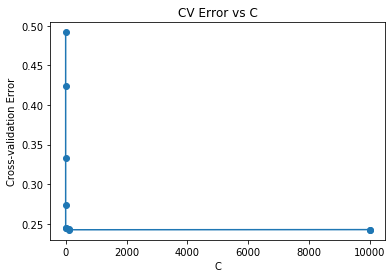

10000

In [107]:
# To choose optimal_alpha using nested cross validation
#from sklearn.model_selection import KFold
#from sklearn.model_selection import KFold
optimal_lambda_avgw2v_grid = lr_grid_plot(std_X_train, y_train)
optimal_lambda_avgw2v_grid

In [108]:
# instantiate learning model 
lr_model =  LogisticRegression(penalty = 'l2', C = optimal_lambda_avgw2v_grid, class_weight = "balanced")
# fitting the model
lr_model.fit(std_X_train, y_train)
# predict the response
pred = lr_model.predict(std_x_test)
# predict probablistic response
pred_prob = lr_model.predict_proba(std_x_test)

Average precision score: 0.5042590625325949
F1_score: 0.0014326647564469916
Auc score: 0.5036330711534873


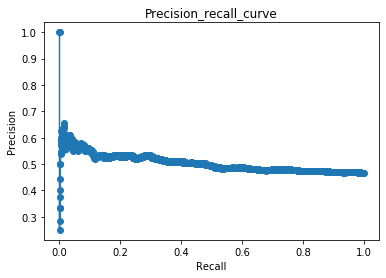

In [109]:
# F1-score, auc, precision_recall_curve
from sklearn.metrics import f1_score, auc, precision_recall_curve, average_precision_score
from sklearn.metrics import auc
f1 = f1_score(y_test, pred)
precision, recall, thresholds = precision_recall_curve(y_test, pred_prob[:,1])
auc = auc(recall, precision)
avg_precision = average_precision_score(y_test, pred_prob[:,1])
print("Average precision score:", avg_precision)
print("F1_score:", f1)
print("Auc score:",auc)
plot_precision_recall_curve(recall, precision)

In [110]:
train_acc_avgw2v_grid = lr_model.score(std_X_train, y_train)
print("Train accuracy:", train_acc_avgw2v_grid)

Train accuracy: 0.7692857142857142


In [111]:
test_acc_avgw2v_grid = accuracy_score(y_test, pred) * 100
print('\nThe accuracy of the logistic regression for c = %f is %.2f%%' % (optimal_lambda_avgw2v_grid, test_acc_avgw2v_grid))


The accuracy of the logistic regression for c = 10000.000000 is 53.53%


In [112]:
# Confusion Matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, pred)
cm

array([[1605,    0],
       [1394,    1]], dtype=int64)

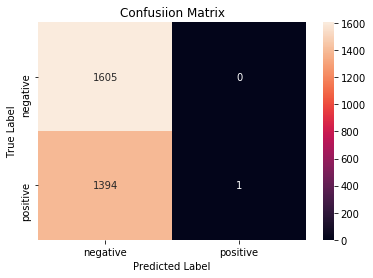

In [113]:
# plot confusion matrix to describe the performance of classifier.
import seaborn as sns
class_label = ["negative", "positive"]
df_cm = pd.DataFrame(cm, index = class_label, columns = class_label)
sns.heatmap(df_cm, annot = True, fmt = "d")
plt.title("Confusiion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [114]:
# To show main classification report
from sklearn.metrics import classification_report
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       0.54      1.00      0.70      1605
           1       1.00      0.00      0.00      1395

    accuracy                           0.54      3000
   macro avg       0.77      0.50      0.35      3000
weighted avg       0.75      0.54      0.37      3000



In [115]:
# model for knn with bag of word
modelsgrid = pd.DataFrame({'Model': ['Logistic Regression with AvgW2V'], 'Hyper Parameter(K) for random search': [optimal_lambda_avgw2v_grid], 'Train Error': [train_acc_avgw2v_grid], 'Test Error': [100 - test_acc_avgw2v_grid], 'Accuracy': [test_acc_avgw2v_grid ], 'Train Accuracy': [train_acc_avgw2v_grid ]}, columns = ["Model", "Hyper Parameter(K) for grid  search", "Train Error", "Test Error", "Accuracy" , "Train Accuracy"])
modelsgrid.sort_values(by='Accuracy', ascending=False)


,Model,Hyper Parameter(K) for grid search,Train Error,Test Error,Accuracy,Train Accuracy
0,Logistic Regression with AvgW2V,NaN,0.769286,46.466667,53.533333,0.769286


now we using random search and plot graph and acc....



**********RandomizedSearchCV**********


Optimal C: 1.6070942146988516

Best penalty: l1


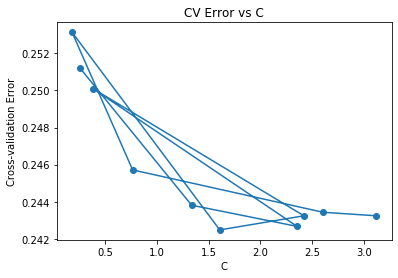

1.6070942146988516

In [116]:
optimal_lambda_avgw2v_random = lr_random_plot(std_X_train, y_train)
optimal_lambda_avgw2v_random

In [139]:
# instantiate learning model 
lr_model =  LogisticRegression(penalty = 'l1', C = optimal_lambda_avgw2v_random, class_weight = "balanced" ,solver = 'liblinear')
# fitting the model
lr_model.fit(std_X_train, y_train)
# predict the response
pred = lr_model.predict(std_x_test)
# predict probablistic response
pred_prob = lr_model.predict_proba(std_x_test)

Average precision score: 0.5433324155283785
F1_score: 0.01276595744680851
Auc score: 0.5427478141801345


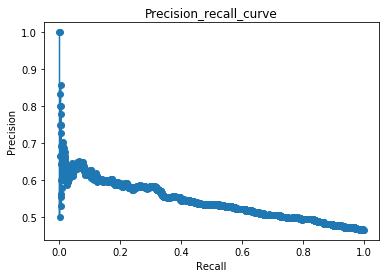

In [140]:
# F1-score, auc, precision_recall_curve
from sklearn.metrics import f1_score, auc, precision_recall_curve, average_precision_score
from sklearn.metrics import auc
f1 = f1_score(y_test, pred)
precision, recall, thresholds = precision_recall_curve(y_test, pred_prob[:,1])
auc = auc(recall, precision)
avg_precision = average_precision_score(y_test, pred_prob[:,1])
print("Average precision score:", avg_precision)
print("F1_score:", f1)
print("Auc score:", auc)
plot_precision_recall_curve(recall, precision)

In [141]:
# Accuracy on train data
train_acc_avgw2v_random = lr_model.score(std_X_train, y_train)
print("Train accuracy", train_acc_avgw2v_random)

Train accuracy 0.7688571428571429


In [142]:
test_acc_avgw2v_random = accuracy_score(y_test, pred) * 100
print('\nThe accuracy of the logistic regression for c = %f is %.2f%%' % (optimal_lambda_avgw2v_random, test_acc_avgw2v_random))


The accuracy of the logistic regression for c = 1.607094 is 53.60%


In [143]:
# Confusion Matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, pred)
cm

array([[1599,    6],
       [1386,    9]], dtype=int64)

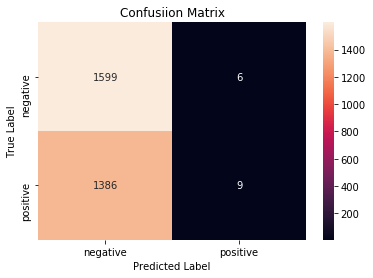

In [144]:
# plot confusion matrix to describe the performance of classifier.
import seaborn as sns
class_label = ["negative", "positive"]
df_cm = pd.DataFrame(cm, index = class_label, columns = class_label)
sns.heatmap(df_cm, annot = True, fmt = "d")
plt.title("Confusiion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [145]:
# To show main classification report
from sklearn.metrics import classification_report
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       0.54      1.00      0.70      1605
           1       0.60      0.01      0.01      1395

    accuracy                           0.54      3000
   macro avg       0.57      0.50      0.35      3000
weighted avg       0.57      0.54      0.38      3000



In [146]:
# model for knn with bag of word
modelsgrid = pd.DataFrame({'Model': ['Logistic Regression with AvgW2V'], 'Hyper Parameter(K) for random search': [optimal_lambda_avgw2v_random], 'Train Error': [train_acc_avgw2v_random], 'Test Error': [100 - test_acc_avgw2v_random], 'Accuracy': [test_acc_avgw2v_random ], 'Train Accuracy': [train_acc_avgw2v_random ]}, columns = ["Model", "Hyper Parameter(K) for random  search", "Train Error", "Test Error", "Accuracy" , "Train Accuracy"])
modelsgrid.sort_values(by='Accuracy', ascending=False)


,Model,Hyper Parameter(K) for random search,Train Error,Test Error,Accuracy,Train Accuracy
0,Logistic Regression with AvgW2V,NaN,0.768857,46.4,53.6,0.768857


In [147]:
# Tried different value of c and finding features weight
# More Sparsity (Fewer elements of W* being non-zero) by increasing Lambda (decreasing C)
C_param = [10, 1, 0.1]

for c in C_param:
    clf = LogisticRegression(penalty = 'l2', C = c, class_weight = "balanced")
    clf.fit(std_X_train, y_train)
    print('\nC value:', c)
    print('Coefficient of each feature:', clf.coef_)
    print('Training accuracy: %0.3f%%' %(clf.score(std_X_train, y_train) * 100))
    print('Test accuracy: %0.3f%%' %(clf.score(std_x_test, y_test) * 100))
    print("Number of non-zero element: ",np.count_nonzero(clf.coef_))


C value: 10
Coefficient of each feature: [[ 0.00848383 -0.60620405  1.03515862  0.65533589  0.15648461  0.92228062
  -0.80744759  1.1031188   0.89810162 -0.19519257  1.4640739  -0.18921371
  -0.8809253  -0.04976299 -0.71912855  0.50439212  0.02823494  1.6211696
  -0.29881907  0.5872598   0.65919896 -0.38554542  0.85800776  0.30177536
   1.01169688 -0.66809725  0.7187686  -1.23946215 -2.04346936  1.19840973
   1.33585381  0.41922118 -0.06542473  0.70289115  0.99010327 -0.84115766
   1.24764557  0.06610112  1.53750591  0.60078048  0.85613074  2.45059312
  -1.89752744 -0.58834554 -0.7994345   1.42071602 -1.15433816 -0.70371335
   0.60259525 -2.26080106]]
Training accuracy: 76.986%
Test accuracy: 53.533%
Number of non-zero element:  50

C value: 1
Coefficient of each feature: [[-0.14852949 -0.60071765  0.94392053  0.5977646   0.23205469  0.93091475
  -0.67484903  0.97730889  0.71760508 -0.04860338  1.30032793 -0.1285786
  -0.80624824 -0.04279967 -0.69409275  0.50268315  0.0992149   1.4650

# Checking for multicollinearity using pertubation test

In [148]:
clf = LogisticRegression(penalty = 'l2', C = optimal_lambda_avgw2v_random, class_weight = "balanced")
clf.fit(std_X_train, y_train)
y_pred = clf.predict(std_x_test)
print("Accuracy score: %0.2f%%" %(accuracy_score(y_test, y_pred) * 100))
print(np.count_nonzero(clf.coef_))

Accuracy score: 53.53%
50


In [149]:
std_X_train.shape

(7000, 50)

In [150]:
np.count_nonzero(clf.coef_)

50

In [151]:
from scipy.sparse import find

# Before adding noise in data
cf = clf.coef_[0]
w_coef1 = cf[np.nonzero(cf)]
print(w_coef1[:50])

[ 0.02241181 -0.52825297  0.95858137  0.59887024  0.15580805  0.79977547
 -0.60865838  0.93484021  0.74440558 -0.06434121  1.28749833 -0.06747753
 -0.79654467 -0.10154702 -0.66498114  0.46813153  0.09358682  1.38925238
 -0.30822788  0.53028464  0.63676646 -0.20195766  0.74117984  0.24564329
  0.7736663  -0.44105637  0.62536183 -1.03306367 -1.79965388  0.9976974
  1.18200471  0.34198814  0.05762823  0.58070046  0.90667812 -0.73879623
  1.05096543  0.08956915  1.31389004  0.51756092  0.76485609  2.23005928
 -1.51473061 -0.41377732 -0.60284507  1.23393394 -0.9330764  -0.65066021
  0.45995443 -1.80302178]


In [152]:
# Generate random normal variable as a noise 
std_X_train_pert = std_X_train
noise = np.random.normal(0, 0.001, size = (std_X_train_pert[np.nonzero(std_X_train_pert)].size,))
#print(noise.shape)
np.nonzero(std_X_train_pert)
std_X_train_pert[np.nonzero(std_X_train_pert)] = noise + std_X_train_pert[np.nonzero(std_X_train_pert)]
std_X_train_pert.shape

(7000, 50)

In [153]:
std_X_train_pert.shape

(7000, 50)

In [156]:
clf = LogisticRegression(penalty = 'l2', C = optimal_lambda_avgw2v_random, class_weight = "balanced" , solver = 'liblinear')
clf.fit(std_X_train_pert, y_train)
y_pred = clf.predict(std_x_test)
print("Accuracy score: %0.2f%%" %(accuracy_score(y_test, y_pred) * 100))
print(np.count_nonzero(clf.coef_))

Accuracy score: 53.60%
50


In [157]:
cf = clf.coef_[0]
w_coef2 = cf[np.nonzero(cf)]
print(w_coef2[:50])

[-7.12769279e-01 -8.14218838e-01  4.62236285e-01  9.62465319e-01
 -1.76656239e-02  1.05014860e+00 -7.46292742e-01  1.46590136e+00
  1.06836361e+00  9.99858864e-05  1.24034389e+00 -1.41421781e-01
 -4.33121609e-01  7.49999125e-01 -5.68099887e-01  5.26373554e-01
  3.16614309e-01  2.17968618e+00 -1.81753405e-01  7.83483342e-01
  5.49025956e-01 -3.33353370e-01  1.16352120e+00  1.27810601e-01
  1.67633720e+00 -9.76427678e-01  1.11838870e+00 -1.00550188e+00
 -1.91670544e+00  1.89319835e+00  7.99368644e-01  7.68893113e-01
  2.96502114e-01  9.09904335e-01  9.30426695e-01 -1.47487460e+00
  1.71962908e+00 -6.52340136e-02  1.17447097e+00  7.83260424e-01
  2.92402250e-01  3.14254397e+00 -2.19615065e+00 -4.85175705e-01
 -5.89363418e-01  1.49799500e+00 -9.86462658e-01 -4.72227093e-01
  7.59997642e-01 -1.69084551e+00]


In [158]:
# Calculate %increase 
cnt = 0
for w1, w2 in zip(w_coef1, w_coef2):
    inc = (abs(w1 - w2)/abs(w2)) * 100
    if inc > 40:
        cnt += 1
print("No of weights that changes more than 40% is:", cnt)

No of weights that changes more than 40% is: 20


In [159]:
# model performence table using grid search
#import itables
models = pd.DataFrame({'Model': ['LogisticRegression with Bow', "LogisticRegression with TFIDF", "LogisticRegression with avgw2v"], 'Hyper Parameter(lambda)': [optimal_lambda_bow_grid, optimal_lambda_tfidf_grid, optimal_lambda_avgw2v_grid], 'Train Error': [1-train_acc_bow_grid, 1-train_acc_tfidf_grid, 1-train_acc_avgw2v_grid], 'Test Error': [100-test_acc_bow_grid, 100-test_acc_tfidf_grid, 100-test_acc_avgw2v_grid], 'Accuracy': [test_acc_bow_grid, test_acc_tfidf_grid, test_acc_avgw2v_grid]}, columns = ["Model", "Hyper Parameter(lambda)", "Train Error", "Test Error", "Accuracy"]).sort_values(by='Accuracy', ascending=False)
models.sort_values(by='Accuracy', ascending=False)

,Model,Hyper Parameter(lambda),Train Error,Test Error,Accuracy
1,LogisticRegression with TFIDF,1,0.000000,18.700000,81.300000
0,LogisticRegression with Bow,1,0.000000,19.900000,80.100000
2,LogisticRegression with avgw2v,10000,0.230714,46.466667,53.533333


In [160]:
# model performence table using random search
models = pd.DataFrame({'Model': ['LogisticRegression with Bow', "LogisticRegression with TFIDF", "LogisticRegression with avgw2v"], 'Hyper Parameter(lambda)': [optimal_lambda_bow_random, optimal_lambda_tfidf_random, optimal_lambda_avgw2v_random], 'Train Error': [1-train_acc_bow_random, 1-train_acc_tfidf_random, 1-train_acc_avgw2v_random], 'Test Error': [100-test_acc_bow_random, 100-test_acc_tfidf_random, 100-test_acc_avgw2v_random], 'Accuracy': [test_acc_bow_random, test_acc_tfidf_random, test_acc_avgw2v_random]}, columns = ["Model", "Hyper Parameter(lambda)", "Train Error", "Test Error", "Accuracy"]).sort_values(by = "Accuracy", ascending = False)
models.sort_values(by='Accuracy', ascending=False)

,Model,Hyper Parameter(lambda),Train Error,Test Error,Accuracy
1,LogisticRegression with TFIDF,3.762734,0.000000,18.666667,81.333333
0,LogisticRegression with Bow,2.331333,0.000000,19.900000,80.100000
2,LogisticRegression with avgw2v,1.607094,0.231143,46.400000,53.600000


# TFIDF Word2Vec 

In [137]:
# TF-IDF weighted Word2Vec
tfidf_feat = tf_idf_vect.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors = [] # the tfidf-w2v for each sentence/review is stored in this list
row=0
for sent in list_of_sent: # for each review/sentence
    sent_vec = np.zeros(1) # as word vectors are of zero length
    weight_sum =0 # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        try:
            vec = w2v_model_train.wv[word]
            # obtain the tf_idfidf of a word in a sentence/review
            tf_idf = X_trn[row, tfidf_feat.index(word)]
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
        except:
            pass
    sent_vec /= weight_sum
    tfidf_sent_vectors.append(sent_vec)
    row += 1

KeyboardInterrupt: 

In [ ]:
len(tfidf_sent_vectors)

In [ ]:
X_train = tfidf_sent_vectors

In [ ]:
# TF-IDF weighted Word2Vec
tfidf_feat = tf_idf_vect.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors_test = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in list_of_sent_test: # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        try:
            vec = w2v_model_test.wv[word]
            # obtain the tf_idfidf of a word in a sentence/review
            tfidf = x_tst[row, tfidf_feat.index(word)]
            sent_vec += (vec * tfidf)
            weight_sum += tfidf
        except:
            pass
    sent_vec /= weight_sum
    tfidf_sent_vectors_test.append(sent_vec)
    row += 1

In [ ]:
len(tfidf_sent_vectors_test)

In [ ]:
x_test = tfidf_sent_vectors_test

In [ ]:
X_train = np.nan_to_num(X_train)

In [ ]:
# Standardization 
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler(with_mean = False)
std_X_train = scaler.fit_transform(X_train)

In [ ]:
std_X_train.shape

In [ ]:
x_test = np.nan_to_num(x_test)

In [ ]:
scaler = StandardScaler(with_mean = False)
std_x_test = scaler.fit_transform(x_test)

In [ ]:
std_x_test.shape

In [ ]:
# To choose optimal_alpha using nested cross validation
optimal_lambda_tfidfw2v_grid = lr_grid_plot(std_X_train, y_train)
optimal_lambda_tfidfw2v_grid

In [ ]:
# instantiate learning model 
lr_model =  LogisticRegression(penalty = 'l2', C = optimal_lambda_tfidfw2v_grid, class_weight = "balanced")
# fitting the model
lr_model.fit(std_X_train, y_train)
# predict the response
pred = lr_model.predict(std_x_test)
# predict probablistic response
pred_prob = lr_model.predict_proba(std_x_test)

In [ ]:
# F1-score, auc, precision_recall_curve
from sklearn.metrics import f1_score, auc, precision_recall_curve, average_precision_score
from sklearn.metrics import auc
f1 = f1_score(y_test, pred)
precision, recall, thresholds = precision_recall_curve(y_test, pred_prob[:,1])
auc = auc(recall, precision)
avg_precision = average_precision_score(y_test, pred_prob[:,1])
print("Average precision score:", avg_precision)
print("F1_score:", f1)
print("Auc score:",auc)
plot_precision_recall_curve(recall, precision)

In [ ]:
# Accuracy on train data
train_acc_tfidfw2v_grid = lr_model.score(std_X_train, y_train)
print("Train accuracy", train_acc_tfidfw2v_grid)

In [ ]:
test_acc_tfidfw2v_grid = accuracy_score(y_test, pred) * 100
print('\nThe accuracy of the logistic regression for c = %0.3f is %f%%' % (optimal_lambda_tfidfw2v_grid, test_acc_tfidfw2v_grid))

In [ ]:
# Confusion Matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, pred)
cm

In [ ]:
# plot confusion matrix to describe the performance of classifier.
import seaborn as sns
class_label = ["negative", "positive"]
df_cm = pd.DataFrame(cm, index = class_label, columns = class_label)
sns.heatmap(df_cm, annot = True, fmt = "d")
plt.title("Confusiion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [ ]:
# To show main classification report
from sklearn.metrics import classification_report
print(classification_report(y_test, pred))

In [ ]:
optimal_lambda_tfidfw2v_random = lr_random_plot(std_X_train, y_train)
optimal_lambda_tfidfw2v_random

In [ ]:
# instantiate learning model 
lr_model =  LogisticRegression(penalty = 'l1', C = optimal_lambda_tfidfw2v_random, class_weight = "balanced")
# fitting the model
lr_model.fit(std_X_train, y_train)
# predict the response
pred = lr_model.predict(std_x_test)
# predict probablistic response
pred_prob = lr_model.predict_proba(std_x_test)

In [ ]:
# F1-score, auc, precision_recall_curve
from sklearn.metrics import f1_score, auc, precision_recall_curve, average_precision_score
from sklearn.metrics import auc
f1 = f1_score(y_test, pred)
precision, recall, thresholds = precision_recall_curve(y_test, pred_prob[:,1])
auc = auc(recall, precision)
avg_precision = average_precision_score(y_test, pred_prob[:,1])
print("Average precision score:", avg_precision)
print("F1_score:", f1)
print("Auc score:",auc)
plot_precision_recall_curve(recall, precision)

In [ ]:
# Accuracy on train data
train_acc_tfidfw2v_random = lr_model.score(std_X_train, y_train)
print("Train accuracy", train_acc_tfidfw2v_random)

In [ ]:
test_acc_tfidfw2v_random = accuracy_score(y_test, pred) * 100
print('\nThe accuracy of the logistic regression for c = %f is %.2f%%' % (optimal_lambda_tfidfw2v_random, test_acc_tfidfw2v_random))

In [ ]:
# Confusion Matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, pred)
cm

In [ ]:
# plot confusion matrix to describe the performance of classifier.
import seaborn as sns
class_label = ["negative", "positive"]
df_cm = pd.DataFrame(cm, index = class_label, columns = class_label)
sns.heatmap(df_cm, annot = True, fmt = "d")
plt.title("Confusiion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [ ]:
# To show main classification report
from sklearn.metrics import classification_report
print(classification_report(y_test, pred))

In [ ]:
# Tried different value of c and finding features weight
# More Sparsity (Fewer elements of W* being non-zero) by increasing Lambda (decreasing C)
C_param = [10, 1, 0.1]

for c in C_param:
    clf = LogisticRegression(penalty='l1', C = c)
    clf.fit(X_train, y_train)
    print('\nC value:', c)
    print('Coefficient of each feature:', clf.coef_)
    print('Training accuracy: %0.3f%%' %(clf.score(std_X_train, y_train) * 100))
    print('Test accuracy: %0.3f%%' %(clf.score(std_x_test, y_test) * 100))
    print("Number of non-zero element: ",np.count_nonzero(clf.coef_))

# Checking for multicollinearity using pertubation test

In [ ]:
clf = LogisticRegression(penalty='l1', C = optimal_lambda_tfidfw2v_random)
clf.fit(std_X_train, y_train)
y_pred = clf.predict(std_x_test)
print("Accuracy score: %0.2f%%" %(accuracy_score(y_test, y_pred) * 100))
print(np.count_nonzero(clf.coef_))

In [ ]:
std_X_train.shape

In [ ]:
np.count_nonzero(clf.coef_)

In [ ]:
from scipy.sparse import find

# Before adding noise in data
cf = clf.coef_[0]
w_coef1 = cf[np.nonzero(cf)]
print(w_coef1[:50])

In [ ]:
# Generate random normal variable as a noise 
std_X_train_pert = std_X_train
noise = np.random.normal(0, 0.001, size = (std_X_train_pert[np.nonzero(std_X_train_pert)].size,))
np.nonzero(std_X_train_pert)
std_X_train_pert[np.nonzero(std_X_train_pert)] = noise + std_X_train_pert[np.nonzero(std_X_train_pert)]
std_X_train_pert.shape

In [ ]:
# Generate random normal variable as a noise 
std_X_train_pert = std_X_train
noise = np.random.normal(0, 0.001, size = (std_X_train_pert[np.nonzero(std_X_train_pert)].size,))
np.nonzero(std_X_train_pert)
std_X_train_pert[np.nonzero(std_X_train_pert)] = noise + std_X_train_pert[np.nonzero(std_X_train_pert)]
std_X_train_pert.shape

In [ ]:
std_X_train_pert.shape

In [ ]:
clf = LogisticRegression(penalty='l1', C = optimal_lambda_tfidfw2v_random)
clf.fit(std_X_train_pert, y_train)
y_pred = clf.predict(x_test)
print("Accuracy score: %0.2f%%" %(accuracy_score(y_test, y_pred) * 100))
print(np.count_nonzero(clf.coef_))

In [ ]:
cf = clf.coef_[0]
w_coef1 = cf[np.nonzero(cf)]
print(w_coef2[:50])

In [ ]:
# Calculate %increase 
cnt = 0
for w1, w2 in zip(w_coef1, w_coef2):
    inc = (abs(w1 - w2)/abs(w1)) * 100  
    if inc > 40:
        cnt += 1
print("No of weights that changes more than 40% is:", cnt)

In [ ]:
# model performence table using grid search
import itable
models = pd.DataFrame({'Model': ['LogisticRegression with Bow', "LogisticRegression with TFIDF", "LogisticRegression with avgw2v", "LogisticRegression with TFIDFW2V"], 'Hyper Parameter(lambda)': [optimal_lambda_bow_grid, optimal_lambda_tfidf_grid, optimal_lambda_avgw2v_grid, optimal_lambda_tfidfw2v_grid], 'Train Error': [1-train_acc_bow_grid, 1-train_acc_tfidf_grid, 1-train_acc_avgw2v_grid, 1-train_acc_tfidfw2v_grid], 'Test Error': [100-test_acc_bow_grid, 100-test_acc_tfidf_grid, 100-test_acc_avgw2v_grid, 100-test_acc_tfidfw2v_grid], 'Accuracy': [test_acc_bow_grid, test_acc_tfidf_grid, test_acc_avgw2v_grid, test_acc_tfidfw2v_grid]}, columns = ["Model", "Hyper Parameter(lambda)", "Train Error", "Test Error", "Accuracy"]).sort_values(by='Accuracy', ascending=False)
itable.PrettyTable(models, tstyle = itable.TableStyle(theme = "theme1"), center = True, header_row = True)

In [ ]:
# model performence table using random search
models = pd.DataFrame({'Model': ['LogisticRegression with Bow', "LogisticRegression with TFIDF", "LogisticRegression with avgw2v", "LogisticRegression with TFIDFW2V"], 'Hyper Parameter(lambda)': [optimal_lambda_bow_random, optimal_lambda_tfidf_random, optimal_lambda_avgw2v_random, optimal_lambda_tfidfw2v_random ], 'Train Error': [1-train_acc_bow_random, 1-train_acc_tfidf_random, 1-train_acc_avgw2v_random, 1-train_acc_tfidfw2v_random], 'Test Error': [100-test_acc_bow_random, 100-test_acc_tfidf_random, 100-test_acc_avgw2v_random, 100-test_acc_tfidfw2v_random], 'Accuracy': [test_acc_bow_random, test_acc_tfidf_random, test_acc_avgw2v_random, test_acc_tfidfw2v_random]}, columns = ["Model", "Hyper Parameter(lambda)", "Train Error", "Test Error", "Accuracy"]).sort_values(by = "Accuracy", ascending = False)
itable.PrettyTable(models, tstyle = itable.TableStyle(theme = "theme1"), center = True, header_row = True)